## Importing libraries

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

In [2]:
import matplotlib.pyplot as plt


## Reading data

In [3]:
datamat = pd.read_csv('student-por.csv')
datamat.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## Creating class labels

In [4]:
datamat = pd.read_csv('student-por.csv')

data1 = datamat
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
for i in data1.columns:
    data1[i] = lb_make.fit_transform(data1[i])
ng = []
for i in data1['G3']:
    if (i>=0 and i<=8):
        ng.append(0)
    elif (i>=9 and i<=12):
        ng.append(1)
    else:
        ng.append(2)

data1['G3'] = ng

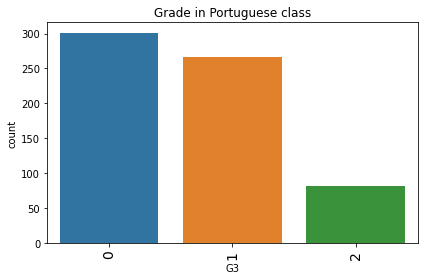

In [5]:
import seaborn as sns
sns.countplot(data1['G3'],label="Grade in Portuguese class")
plt.title('Grade in Portuguese class')
plt.xticks(fontsize=14, rotation=90)
plt.tight_layout()
plt.show()

## Implementing algorithm

In [6]:
def entropy(target_col):
    elements,counts = np.unique(target_col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy

def InfoGain(data,split_attribute_name,target_name="G3"):
    total_entropy = entropy(data[target_name]) 
    vals,counts= np.unique(data[split_attribute_name],return_counts=True)
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain


def ID3(data,originaldata,features,target_attribute_name="G3",parent_node_class = None):
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    elif len(data)==0:
        return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],return_counts=True)[1])]

    elif len(features) ==0:
        return parent_node_class

    else:
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],return_counts=True)[1])]
        
        item_values = [InfoGain(data,feature,target_attribute_name) for feature in features]
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]

        tree = {best_feature:{}}
        
        
        features = [i for i in features if i != best_feature]
        
        for value in np.unique(data[best_feature]):
            value = value
            sub_data = data.where(data[best_feature] == value).dropna()
            
            subtree = ID3(sub_data,dataset,features,target_attribute_name,parent_node_class)
            
            tree[best_feature][value] = subtree
            
        return(tree)    

    
def predictt(query,tree,default = 1):
    #1.
    for key in list(query.keys()):
        if key in list(tree.keys()):
            #2.
            try:
                result = tree[key][query[key]] 
            except:
                return default
            #3.
            result = tree[key][query[key]]
            #4.
            if isinstance(result,dict):
                return predictt(query,result)
            else:
                return result

## Sampling the data for train test split

In [7]:
from sklearn.utils import resample
def train_test_split(dataset):
    training_data = dataset.iloc[:int(2*data1.shape[0]/3)].reset_index(drop=True)
    train_data = resample(data1, replace=True, n_samples=int(2*data1.shape[0]/3), random_state=1).reset_index(drop=True)
    testing_data = dataset.iloc[int(2*data1.shape[0]/3):].reset_index(drop=True)
    test_data = resample(data1, replace=True, n_samples=int(1*data1.shape[0]/3), random_state=2).reset_index(drop=True)
    return train_data,test_data

dataset = data1
training_data = train_test_split(dataset)[0]
testing_data = train_test_split(dataset)[1]

In [8]:
tree = ID3(training_data,training_data,training_data.columns[:-1])

In [9]:
pprint(tree)

{'G2': {0: 0.0,
        1: 0.0,
        2: 0.0,
        3: 0.0,
        4: 0.0,
        5: 0.0,
        6: {'G1': {5.0: 0.0,
                   6.0: 0.0,
                   7.0: 0.0,
                   8.0: 0.0,
                   9.0: 0.0,
                   10.0: 1.0}},
        7: {'absences': {0.0: {'age': {0.0: {'address': {0.0: 1.0, 1.0: 0.0}},
                                       1.0: 0.0,
                                       2.0: 0.0,
                                       3.0: 1.0}},
                         1.0: 1.0,
                         2.0: {'age': {0.0: 0.0,
                                       1.0: {'school': {0.0: 0.0, 1.0: 1.0}},
                                       2.0: {'Fedu': {1.0: 0.0,
                                                      3.0: 1.0,
                                                      4.0: 1.0}},
                                       3.0: 1.0}},
                         4.0: {'age': {1.0: 0.0, 2.0: 1.0, 3.0: 0.0, 4.0: 0.0}},
           

In [10]:
def test(data,tree):
    queries = data.iloc[:,:-1].to_dict(orient = "records")
    predicted = pd.DataFrame(columns=["predicted"]) 
    for i in range(len(data)):
        predicted.loc[i,"predicted"] = predictt(queries[i],tree,1.0) 
    print('The prediction accuracy is: ',(np.sum(predicted["predicted"] == data["G3"])/len(data))*100,'%')

In [11]:
test(testing_data,tree)

The prediction accuracy is:  95.37037037037037 %


## kFold cross validation

In [12]:
from random import randrange
def cross_validation_split(dataset, folds):
        dataset_split = []
        df_copy = dataset
        fold_size = int(df_copy.shape[0] / folds)
        
        for i in range(folds):
            fold = []
            while len(fold) < fold_size:
                r = randrange(df_copy.shape[0])
                index = df_copy.index[r]
                fold.append(df_copy.loc[index].values.tolist())
                df_copy = df_copy.drop(index)
            dataset_split.append(np.asarray(fold))
        return dataset_split 

In [13]:
def testkfold(data,tree):
    queries = data.iloc[:,:-1].to_dict(orient = "records")
    predicted = pd.DataFrame(columns=["predicted"]) 
    for i in range(len(data)):
        predicted.loc[i,"predicted"] = predictt(queries[i],tree,1.0) 
    return ((np.sum(predicted["predicted"] == data["G3"])/len(data))*100)

In [14]:
def kfoldCV(dataset, f, k):
    data=cross_validation_split(dataset,f)
    result=[]
    for i in range(f):
        r = list(range(f))
        r.pop(i)
        for j in r :
            if j == r[0]:
                cv = data[j]
            else:    
                cv=np.concatenate((cv,data[j]), axis=0)
        dtf = pd.DataFrame(cv)
        dtf.columns = data1.columns
        if True:
            acc = testkfold(dtf,tree)
        result.append(acc)
    return np.mean(result)

95.23809523809523
95.23809523809521
95.23809523809523
95.23809523809523
95.23809523809524
96.19047619047619
95.71428571428571
95.23809523809523
95.23809523809524


Text(0, 0.5, 'Accuracy')

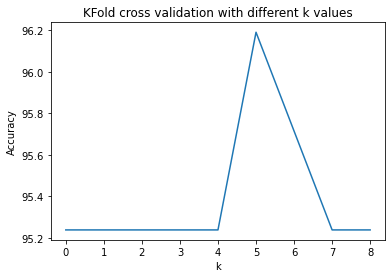

In [15]:
valcatch = []
for i in range(1,10):
    v = kfoldCV(testing_data,10,i)
    print(v)
    valcatch.append(v)
plt.plot(valcatch)
plt.title('KFold cross validation with different k values')
plt.xlabel('k')
plt.ylabel('Accuracy')

In [16]:
def predict_y(data,tree):
    queries = data.iloc[:,:-1].to_dict(orient = "records")
    predicted = pd.DataFrame(columns=["predicted"]) 
    for i in range(len(data)):
        predicted.loc[i,"predicted"] = predictt(queries[i],tree,1.0) 
    return list(predicted.predicted)

In [22]:
y_true = testing_data.iloc[:,-1]
y_pred = predict_y(testing_data,tree)

## confusion matrix

In [23]:
currentDataClass = y_true
predictedClass = y_pred
classes = int(max(currentDataClass) - min(currentDataClass)) + 1

counts = [[sum([(currentDataClass[i] == true_class) and (predictedClass[i] == pred_class) 
                for i in range(len(currentDataClass))])
           for pred_class in range(0, classes )] 
           for true_class in range(0, classes )]
conf_mat = pd.DataFrame(counts)

In [24]:
conf_mat

,0,1,2
0,95,3,0
1,4,86,1
2,1,1,25


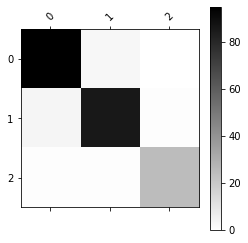

In [25]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(conf_mat)

## performance metrics

In [26]:
precision_1 = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0]+conf_mat[2][0])
precision_2 = conf_mat[1][1]/(conf_mat[0][1]+conf_mat[1][1]+conf_mat[2][1])
precision_3 = conf_mat[2][2]/(conf_mat[0][2]+conf_mat[1][2]+conf_mat[2][2])
recall_1 = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1]+conf_mat[0][2])
recall_2 = conf_mat[1][1]/(conf_mat[1][0]+conf_mat[1][1]+conf_mat[1][2])
recall_3 = conf_mat[2][2]/(conf_mat[2][0]+conf_mat[2][1]+conf_mat[2][2])
f1_score_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1)
f1_score_2 = 2 * precision_2 * recall_2 / (precision_2 + recall_2)
f1_score_3 = 2 * precision_3 * recall_3 / (precision_3 + recall_3)